In [1]:
# Imports
import requests
import pandas as pd
import geopandas as gp
from pandas.io.json import json_normalize
from dateutil import parser
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from zipfile import ZipFile

# Setup pandas to show all columns and limit row previews to 10 rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 12)

#### The dataset for the 2015 Street Tree Census is available at https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/pi5s-9p35. It contains information about the tree species, diameter, and health perception. Blockface data is included to show data collection and release status for the entire city.

In [2]:
# Unzip the previously downloaded and compressed CSV file
zf = ZipFile('data/2015_street_tree_census.zip', 'r')
zf.extractall('data')
zf.close()

# Load the data into a dataframe
trees = pd.read_csv('data/2015_street_tree_census.csv')
# Preview the data

trees.head(5)

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,steward,guards,sidewalk,user_type,problems,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,address,postcode,zip_city,community board,borocode,borough,cncldist,st_assem,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,08/27/2015,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,None,None,NoDamage,TreesCount Staff,None,No,No,No,No,No,No,No,No,No,108-005 70 AVENUE,11375,Forest Hills,406,4,Queens,29,28,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,200540,315986,09/03/2015,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,None,None,Damage,TreesCount Staff,Stones,Yes,No,No,No,No,No,No,No,No,147-074 7 AVENUE,11357,Whitestone,407,4,Queens,19,27,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,204026,218365,09/05/2015,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,1or2,None,Damage,Volunteer,None,No,No,No,No,No,No,No,No,No,390 MORGAN AVENUE,11211,Brooklyn,301,3,Brooklyn,34,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09
3,204337,217969,09/05/2015,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,None,None,Damage,Volunteer,Stones,Yes,No,No,No,No,No,No,No,No,1027 GRAND STREET,11211,Brooklyn,301,3,Brooklyn,34,53,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,1002420.358,199244.2531,34.0,449.0,3338342.0,3.029250e+09
4,189565,223043,08/30/2015,21,0,OnCurb,Alive,Good,Tilia americana,American linden,None,None,Damage,Volunteer,Stones,Yes,No,No,No,No,No,No,No,No,603 6 STREET,11215,Brooklyn,306,3,Brooklyn,39,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.666778,-73.975979,990913.775,182202.4260,39.0,165.0,3025654.0,3.010850e+09


In [3]:
# Get the dataframe shape
trees.shape

(683788, 45)

#### removing the spaces and coverting the column names to lowercase and dropping inapplicable columns.

In [4]:
cols = trees.columns
cols = cols.map(lambda x: x.replace(' ', '_').lower())
trees.columns = cols

# Drop the unnecessary columns
trees = trees.drop([  'block_id',
                      'tree_dbh',
                      'stump_diam',
                      'curb_loc',
                      'steward',
                      'guards',
                      'sidewalk',
                      'user_type',
                      'problems',
                      'root_stone',
                      'root_grate',
                      'root_other',
                      'trunk_wire',
                      'trnk_light',
                      'trnk_other',
                      'brch_light',
                      'brch_shoe',
                      'brch_other',
                      'address',
                      'zip_city',
                      'community_board',
                      'borocode',
                      'cncldist',
                      'st_assem',
                      'st_senate',
                      'nta',
                      'nta_name',
                      'boro_ct',
                      'state',
                      'x_sp',
                      'y_sp',
                      'council_district',
                      'zip_city',
                      'community_board',
                      'census_tract',
                      'bin',
                      'bbl'
                     ], axis=1)

# Preview the data
trees.head(5)

,tree_id,created_at,status,health,spc_latin,spc_common,postcode,borough,latitude,longitude
0,180683,08/27/2015,Alive,Fair,Acer rubrum,red maple,11375,Queens,40.723092,-73.844215
1,200540,09/03/2015,Alive,Fair,Quercus palustris,pin oak,11357,Queens,40.794111,-73.818679
2,204026,09/05/2015,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,11211,Brooklyn,40.717581,-73.936608
3,204337,09/05/2015,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,11211,Brooklyn,40.713537,-73.934456
4,189565,08/30/2015,Alive,Good,Tilia americana,American linden,11215,Brooklyn,40.666778,-73.975979


#### Unzipping and loading data into pandas from The Forestry Service at https://data.cityofnewyork.us/Environment/Forestry-Service-Requests/mu46-p9is.

In [5]:
# Unzip the previously downloaded and compressed CSV file
zf = ZipFile('data/forestry_service_requests.zip', 'r')
zf.extractall('data')
zf.close()

# Load the data into a dataframe
service_requests = pd.read_csv('data/forestry_service_requests.csv')
# Preview the data
service_requests.head(5)

,objectid,complaintnumber,srcategory,srtype,srpriority,srsource,srstatus,srresolution,boroughcode,communityboard,buildingnumber,streetname,crossstreet1,crossstreet2,taxclass,locationdetails,complaintdetails,parkname,parkzone,notestocustomer,zipcode,citycouncil,statesenate,stateassembly,congressional,sanitationzone,physicalid,servicerequestparentglobalid,geometry,globalid,initiateddate,closeddate,createddate,updateddate,descriptor1,complainttype,callerzipcode,srcallertype,callercity,callerstate,latitude,longitude,census_tract,bin,bbl,nta,location
0,15829940,311-01062192,Hazard,Tree Leaning,Routine,Department of Parks and Recreation - Public We...,Closed,Work Completed,Manhattan,112.0,340,HAVEN AVENUE,CROSS BRONX EXPWY SB ET 1 A,CROSS BRONX EXPWY SB ET 1 A,2.0,the tree is located on the north side of the 3...,NaN,NaN,NaN,Limb has been removed,10033.0,10.0,31.0,71.0,13.0,NaN,27926.0,NaN,NaN,BE71B4BB-F659-4B13-8820-AACF4F95BE4A,11/05/2019 21:26:46,11/07/2019 19:42:00,11/05/2019 21:26:00,11/07/2019 19:42:00,Tree Leaning/Uprooted,Damaged Tree,10003,Business Business,New York,New York,40.850912,-73.941544,265.0,1079979.0,1.021770e+09,Washington Heights South,NaN
1,105235,1-1-1077952256,Hazard,Hanging Limb from other Branches,Routine,3-1-1 Call Center,Closed,Inspected - Condition Not Found,Queens,410.0,90-07,159 AVENUE,90 STREET,91 STREET,NaN,CONDITION UNFOUNDED,RIGHT SIDE OF TREE BRANCHES ARE CRACKED AND AB...,NaN,NaN,CONDITION UNFOUNDED,11414.0,32.0,15.0,23.0,8.0,NaN,29668.0,NaN,NaN,F9B71AA3-0E17-40E2-BC36-3DCC80329DA4,03/12/2015 18:47:52,03/19/2015 04:00:00,03/12/2015 04:00:00,03/19/2015 04:00:00,Branch Cracked and Will Fall,Damaged Tree,NaN,NaN,NaN,NaN,40.658802,-73.842531,892.0,4293012.0,4.139890e+09,Lindenwood-Howard Beach,NaN
2,15852995,311-01114710,Plant Tree,Street Tree,Routine,Department of Parks and Recreation - Public We...,Open,NaN,Brooklyn,303.0,60,VAN BUREN STREET,TOMPKINS AVENUE,THROOP AVENUE,1.0,NaN,NaN,NaN,NaN,NaN,11221.0,36.0,25.0,56.0,8.0,NaN,85463.0,NaN,NaN,51295F52-4873-4471-BA45-45ED4612B622,11/11/2019 17:04:25,NaN,11/11/2019 17:04:25,NaN,For One Address,New Tree Request,11221,NaN,Brooklyn,NY,40.690047,-73.943301,263.0,3050233.0,3.017950e+09,Bedford,NaN
3,9470373,NaN,Hazard,Hanging Limb,Routine,Park Inspection Program,Closed,Work Completed,Bronx,211.0,/,/,NaN,NaN,NaN,dia 96182- dangling over benches at Barnes Ave...,NaN,Pelham Parkway,X003-ZN01,hanging limb and tree have been removed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6CB7B7C8-4AC5-4602-82A5-81679C27267F,NaN,05/02/2018 12:22:27,11/01/2017 15:13:00,05/02/2018 12:22:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15813147,311-01026496,Root/Sewer/Sidewalk,Trees and Sidewalks,Routine,3-1-1 Call Center,Open,NaN,Bronx,211.0,2730,LURTING AVENUE,ALLERTON AVENUE,ARNOW AVENUE,NaN,NaN,THIS TREE IS LEANING AND INTO MY PROPERTY AND ...,NaN,NaN,NaN,10469.0,13.0,36.0,80.0,14.0,NaN,86779.0,NaN,NaN,13C04CAC-B979-4782-82A2-CACC31D583C3,11/01/2019 21:19:08,NaN,11/01/2019 21:23:48,NaN,Trees and Sidewalks Program,Root/Sewer/Sidewalk Condition,10469,NaN,BRONX,NY,40.866033,-73.856763,344.0,2053968.0,2.045200e+09,Allerton-Pelham Gardens,NaN


In [6]:
service_requests.shape

(429425, 47)

#### dropping inapplicable columns.

In [7]:
# Drop the unnecessary columns
service_requests = service_requests.drop(['objectid',
                                          'complaintnumber',
                                          'srcategory',
                                          'complaintdetails',
                                          'srpriority',
                                          'srsource',
                                          'srresolution',
                                          'communityboard',
                                          'buildingnumber',
                                          'streetname',
                                          'crossstreet1',
                                          'crossstreet2',
                                          'taxclass',
                                          'locationdetails',
                                          'parkname',
                                          'parkzone',
                                          'notestocustomer',
                                          'citycouncil',
                                          'statesenate',
                                          'stateassembly',
                                          'congressional',
                                          'sanitationzone',
                                          'servicerequestparentglobalid',
                                          'geometry',
                                          'globalid',
                                          'initiateddate',
                                          'callerzipcode',
                                          'descriptor1',
                                          'srcallertype',
                                          'callercity',
                                          'callerstate',
                                          'census_tract',
                                          'bin',
                                          'bbl',
                                          'nta',
                                          'location',
                                          'physicalid'
                                         ], axis=1)

# Preview the data
service_requests.head(5)

,srtype,srstatus,boroughcode,zipcode,closeddate,createddate,updateddate,complainttype,latitude,longitude
0,Tree Leaning,Closed,Manhattan,10033.0,11/07/2019 19:42:00,11/05/2019 21:26:00,11/07/2019 19:42:00,Damaged Tree,40.850912,-73.941544
1,Hanging Limb from other Branches,Closed,Queens,11414.0,03/19/2015 04:00:00,03/12/2015 04:00:00,03/19/2015 04:00:00,Damaged Tree,40.658802,-73.842531
2,Street Tree,Open,Brooklyn,11221.0,NaN,11/11/2019 17:04:25,NaN,New Tree Request,40.690047,-73.943301
3,Hanging Limb,Closed,Bronx,NaN,05/02/2018 12:22:27,11/01/2017 15:13:00,05/02/2018 12:22:27,NaN,NaN,NaN
4,Trees and Sidewalks,Open,Bronx,10469.0,NaN,11/01/2019 21:23:48,NaN,Root/Sewer/Sidewalk Condition,40.866033,-73.856763


#### transforming the createddate, closeddate, and updateddate columns into proper datetime objects. 

In [8]:
# Convert the date columns into Python datetime objects
service_requests['createddate'] =  pd.to_datetime(service_requests['createddate'])
service_requests['closeddate'] =  pd.to_datetime(service_requests['closeddate'])
service_requests['updateddate'] =  pd.to_datetime(service_requests['updateddate'])

# Preview the data
service_requests.head()

,srtype,srstatus,boroughcode,zipcode,closeddate,createddate,updateddate,complainttype,latitude,longitude
0,Tree Leaning,Closed,Manhattan,10033.0,2019-11-07 19:42:00,2019-11-05 21:26:00,2019-11-07 19:42:00,Damaged Tree,40.850912,-73.941544
1,Hanging Limb from other Branches,Closed,Queens,11414.0,2015-03-19 04:00:00,2015-03-12 04:00:00,2015-03-19 04:00:00,Damaged Tree,40.658802,-73.842531
2,Street Tree,Open,Brooklyn,11221.0,NaT,2019-11-11 17:04:25,NaT,New Tree Request,40.690047,-73.943301
3,Hanging Limb,Closed,Bronx,NaN,2018-05-02 12:22:27,2017-11-01 15:13:00,2018-05-02 12:22:27,NaN,NaN,NaN
4,Trees and Sidewalks,Open,Bronx,10469.0,NaT,2019-11-01 21:23:48,NaT,Root/Sewer/Sidewalk Condition,40.866033,-73.856763


# The NYC Street Tree Map Favorite Trees dataset

In [9]:
# Download the data
trees_response = requests.get('https://www.nycgovparks.org/tree-map-feeds/favorite-trees.json')

# Check the response code
# Print an error if the status code isn't 200
if trees_response.status_code != 200:
    print(trees_response.status_code)
    print("There was an error with the request.")
# Otherwise load the response
else:
    trees_json = trees_response.json()
    # Use the pandas json_normalize method to create a pandas dataframe
    fav_trees = json_normalize(trees_json['data'])

fav_trees.head(5)

,treeId,numberOfTimesFavorited
0,89223,1
1,90423,1
2,104829,1
3,108832,2
4,118055,1


#### Checking dataset record and column count:

In [10]:
# Get the dataframe shape
fav_trees.shape

(6188, 2)

#### merging this dataset with the trees dataframe and renaming the treeId column to tree_id to match the trees dataframe tree identifier column:

In [11]:
# Rename the column
fav_trees.rename(columns={'treeId': 'tree_id'}, inplace=True)
# Merge the dataframse
trees = pd.merge(trees, fav_trees, how='left', on='tree_id')
# Preview the data
trees.head(5)

,tree_id,created_at,status,health,spc_latin,spc_common,postcode,borough,latitude,longitude,numberOfTimesFavorited
0,180683,08/27/2015,Alive,Fair,Acer rubrum,red maple,11375,Queens,40.723092,-73.844215,NaN
1,200540,09/03/2015,Alive,Fair,Quercus palustris,pin oak,11357,Queens,40.794111,-73.818679,NaN
2,204026,09/05/2015,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,11211,Brooklyn,40.717581,-73.936608,NaN
3,204337,09/05/2015,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,11211,Brooklyn,40.713537,-73.934456,NaN
4,189565,08/30/2015,Alive,Good,Tilia americana,American linden,11215,Brooklyn,40.666778,-73.975979,NaN


# Data Analysis
## Which borough has the most trees?

In [12]:
trees.groupby('borough') \
     .tree_id \
     .count() \
     .reset_index() \
     .rename(columns={'tree_id':'tree_count'}) \
     .sort_values(['tree_count'], ascending=[False])

,borough,tree_count
3,Queens,250551
1,Brooklyn,177293
4,Staten Island,105318
0,Bronx,85203
2,Manhattan,65423


### Queens has the most trees with 250,551.


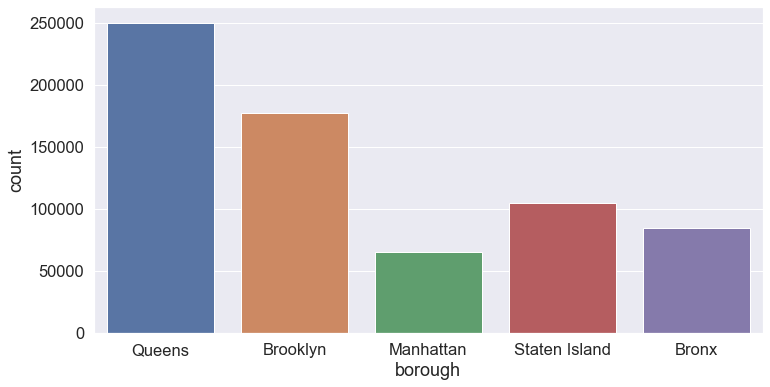

In [13]:
# count plot:
# Set the font scale to make the labels and ticks more readable
sb.set(font_scale = 1.5)
# Set the figure size
fig, axes = plt.subplots(figsize = (12, 6))
# Create the plot
plot = sb.countplot(trees['borough'])

## How many dead trees there are?

this can be achieved by querying the trees dataset to find trees that have a status not equal to alive and then get the shape:

In [15]:
# Query the trees dataframe and print the shape 
print(trees.query('status != "Alive"').shape[0])

31615


### There are 31,615 dead trees.

## How many are still standing? How many are stumps?

In [16]:
# Query the trees dataframe, group by status, and count the rows
trees.query('status != "Alive"') \
     .groupby('status') \
     .tree_id \
     .count() \
     .reset_index() \
     .rename(columns={'tree_id':'tree_count'}) \
     .sort_values(['tree_count'], ascending=[False])

,status,tree_count
1,Stump,17654
0,Dead,13961


### There are 13,961 standing dead trees and 17,654 stumps.


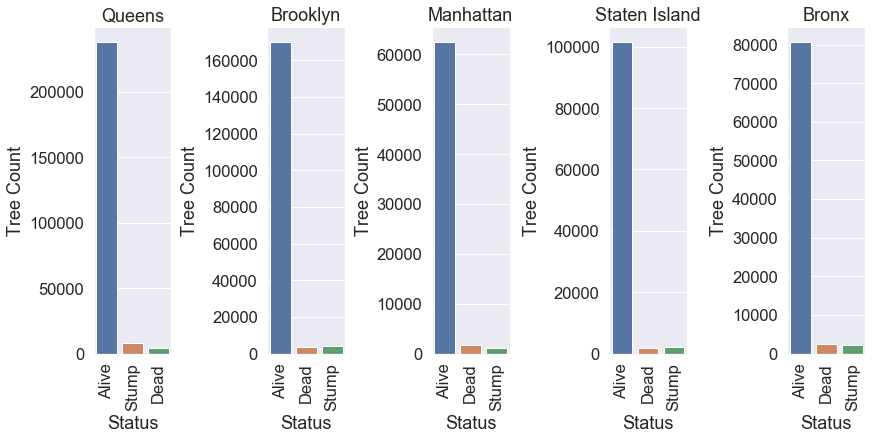

In [17]:
# Get the unique borough values from the tree dataframe
boroughs = trees.borough.unique()

# Set the font scale to make the labels and ticks more readable
sb.set(font_scale = 1.5)
# Set the number of columns for the subplots, the figure size, and constrained layout
fig, axes = plt.subplots(ncols = len(boroughs),
                         figsize = (12, 6),
                         constrained_layout = True)

# Loop through the boroughs to generate the countplot as subplots
for i, b in enumerate(boroughs):
    data = trees.query('borough == "{}"'.format(b))
    # Create the subplot
    plot = sb.countplot(data['status'], ax = axes[i%len(boroughs)])
    # Set the tick labels for the x axis
    plot.set_xticklabels(data['status'].unique(), rotation = 90)
    # Set the axis labels
    plot.set(xlabel = "Status",
             ylabel = "Tree Count", 
             title = "{}".format(b))

## What is the most common species?
#### grouping by species and counting the number of trees:

In [18]:
# Group by species name, count the rows, and sort descending by the count
trees.groupby('spc_common') \
     .tree_id \
     .count() \
     .reset_index() \
     .rename(columns={'tree_id':'tree_count'}) \
     .sort_values(['tree_count'], ascending=[False]) \
     .head(5)

,spc_common,tree_count
31,London planetree,87014
82,honeylocust,64264
12,Callery pear,58931
96,pin oak,53185
32,Norway maple,34189


### The most common species is the London planetree with 87,014 trees in NYC.

## What is the least common species?
#### grouping by species and counting the number trees:

In [19]:
# Group by species name, count the rows, and sort ascending by the count
trees.groupby('spc_common') \
     .tree_id \
     .count() \
     .reset_index() \
     .rename(columns={'tree_id':'tree_count'}) \
     .sort_values(['tree_count'], ascending=[True]) \
     .head(5)

,spc_common,tree_count
44,Virginia pine,10
39,Scots pine,25
36,Osage-orange,29
98,pitch pine,33
53,black pine,37


### The least common species is the Virginia pine with 10 trees in NYC.